# Import libraries

In [1]:
# ! pip uninstall -y tensorflow
# ! pip install tensorflow==2.10.*

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from multiprocessing import Pool
from outer_function_daily import outer_function
from functools import partial
import numpy as np
from sklearn.metrics import r2_score
import csv

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Normalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [3]:
# Check if it detects GPU
tf.config.list_physical_devices('GPU') # need to use `! pip install tensorflow==2.10.*` to use gpu on windows 11 natively

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Import Data

## Stock price data

In [4]:
# Import data
stocks_df = pd.read_csv("data/price.csv")

# Set date-time index
stocks_df['Date'] = pd.to_datetime(stocks_df["Date"], format='%Y-%m-%d')
stocks_df = stocks_df.set_index(stocks_df['Date'])
stocks_df = stocks_df.drop(columns = ["Date"])

# Drop all columns which only contain nan values
boolean = []
for stock in stocks_df.columns:
    boolean.append(not stocks_df[stock].isnull().all())
stocks_df = stocks_df.iloc[:, boolean]

stocks_df

,AAPL,MSFT,GOOGL,GOOG,AMZN,BRK.B,UNH,JNJ,XOM,V,...,UPST,TAP,WE,CVNA,NVAX,EHAB,OPEN,UWMC,MBC,FG
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,13.291009,NaN,NaN,0.264886,NaN,NaN,NaN,1.888242,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.963844,NaN,NaN,NaN
1990-01-03,NaN,13.488728,NaN,NaN,0.266664,NaN,NaN,NaN,1.895060,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.998913,NaN,NaN,NaN
1990-01-04,NaN,13.510702,NaN,NaN,0.267553,NaN,NaN,NaN,1.891651,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.998913,NaN,NaN,NaN
1990-01-05,NaN,13.378882,NaN,NaN,0.268442,NaN,NaN,NaN,1.871201,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.998913,NaN,NaN,NaN
1990-01-08,NaN,13.378882,NaN,NaN,0.270220,NaN,NaN,NaN,1.880794,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.998913,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,147.929993,44.090000,12.53,139.380005,132.300003,160.580002,167.380005,87.620003,106.489998,62.240002,...,128.589996,33.619999,125.192581,247.149994,32.669998,28.730000,46.130001,68.559998,113.540001,142.470001
2022-12-21,150.089996,44.869999,13.03,142.289993,135.449997,162.210007,169.320007,87.070000,108.139999,63.360001,...,128.779999,33.950001,126.839455,250.839996,33.049999,29.309999,47.570000,69.930000,112.769997,144.919998
2022-12-22,149.009995,43.849998,12.56,142.080002,132.229996,163.270004,169.270004,84.870003,108.029999,62.849998,...,128.820007,33.459999,126.550003,247.509995,32.439999,28.950001,48.279999,65.940002,109.360001,145.029999


## Categorical variable data

In [5]:
# Read data
cat_variables = pd.read_csv("data/categorical.csv")
cat_variables = cat_variables.set_index("Unnamed: 0")
cat_variables = cat_variables.rename_axis(None, axis = 0)
cat_variables = cat_variables.dropna(axis="columns")

# Drop stocks such that the remaining stocks are those in both cat_variables and stocks_df
intersection = list(set(stocks_df.columns) & set(cat_variables.columns))
cat_variables = cat_variables[intersection]
stocks_df = stocks_df[intersection]

cat_variables

,LCID,MRVI,CIEN,DAR,SNX,LIN,VMI,OGN,W,HIW,...,UHS,CSCO,BKR,WMT,GFS,NKE,VOYA,LAMR,KEY,WBS
sectors,Consumer Discretionary,Health Care,Information Technology,Consumer Staples,Information Technology,Materials,Industrials,Health Care,Consumer Discretionary,Real Estate,...,Health Care,Information Technology,Energy,Consumer Staples,Information Technology,Consumer Discretionary,Financials,Real Estate,Financials,Financials


In [6]:
# Get unique categories for each categorical variable
cats_df = pd.DataFrame()
for cat in cat_variables.index:
    uniques = list(cat_variables.loc[cat, :].unique())
    categories = np.sort(uniques)
    cats_df[cat] = categories

cats_df

,sectors
0,Communication Services
1,Consumer Discretionary
2,Consumer Staples
3,Energy
4,Financials
5,Health Care
6,Industrials
7,Information Technology
8,Information technology
9,Materials


## Numerical features data

In [7]:
# Read data
features_daily = pd.read_csv("data/features.csv")
features_daily['Date'] = pd.to_datetime(features_daily["Date"], format='%Y-%m-%d')
features_daily = features_daily.set_index("Date")
features_daily = features_daily.dropna()

# Make names smaller to use in file names
print(features_daily.columns)
features_daily.columns = ['BCI', 'CCI', 'CLI', '3m%', 'Broad$', 'Construction', 'Consumer_prices', 'Manu$',
       'Indu_production', 'Long%', 'MCI', 'Narrow$', 'Overnight%', 'Cars', 'producer$', 'Retail_volume',
       'Total_employment', 'Total_manu']

features_daily

Index(['BCI', 'CCI', 'CLI', '3 month interbank rate', 'Broad money',
       'Construction', 'Consumer prices', 'Manufacturing hourly earnings',
       'Industrial production', 'Long-term interest rate',
       'Manufacturing confidence indicator', 'Narrow money',
       'Overnight interbank rate', 'Car registrations',
       'Manufacturing producer prices', 'Retail trade volume',
       'Total employment', 'Total manufacturing'],
      dtype='object')


,BCI,CCI,CLI,3m%,Broad$,Construction,Consumer_prices,Manu$,Indu_production,Long%,MCI,Narrow$,Overnight%,Cars,producer$,Retail_volume,Total_employment,Total_manu
Date,,,,,,,,,,,,,,,,,,
1990-01-01,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-02,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-03,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-04,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-05,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796
2022-12-24,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796
2022-12-25,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796


# Training neural network on created data

In [8]:
# Convert to a numpy array for speedy opterations later on
stocks_np = stocks_df.to_numpy()

# Convert to a numpy array for speedy opterations later on
cat_variables_np = cat_variables.to_numpy()

# Convert to a numpy array for speedy opterations later on
features_daily_np = features_daily.to_numpy()

In [9]:
root_folder = "results"
overview_folder = "overview"
details_folder = "details"

# Create/load file to store results of each model
try:
    os.makedirs(f"{root_folder}/{overview_folder}")
except FileExistsError:
    pass


model_results_path = f"{root_folder}/{overview_folder}/model results.csv"
try:
    results = pd.read_csv(model_results_path)
except FileNotFoundError:
    # If the file does not exist then we create the file
    with open(model_results_path, "w") as f:
        f.write(",".join(["features","lines", "years", "layers", "neurons per layer", "total neurons", "batch size", "technique", "model name","val_loss", "val_r2"]) + "\n")
    results = pd.read_csv(model_results_path)

results

,features,lines,years,layers,neurons per layer,total neurons,batch size,technique,model name,val_loss,val_r2
0,[],20,2,2,32,64,1024,base,1,16.469419,0.928695
1,[],20,2,2,32,64,1024,base,2,16.568808,0.927042
2,[sectors Cars Indu _production _manu$],24,3,3,64,192,512,base,3,16.407534,0.929503
3,[BCI Broad$ CCI CLI Construction],28,2,4,128,512,1024,base,4,16.332748,0.927957
4,[sectors Consumer_prices Retail_volume Total_e...,32,3,5,256,1280,512,base,5,16.615372,0.918308
5,[],36,2,2,16,32,2048,base,6,16.615511,0.926276
6,[sectors Cars _manu$ Narrow$],36,3,3,32,96,2048,base,7,16.456457,0.925978
7,[],44,2,2,16,32,2048,base,8,16.588154,0.926785
8,[sectors Cars Indu _production _manu$ Narrow$],44,3,3,32,96,2048,base,9,16.465776,0.927446
9,[sectors Cars Indu _production _manu$ Narrow$],44,3,3,32,96,2048,dropout layers,10,35.992115,0.806404


## Training the models

In [10]:
def plot(history, model, x_test, y_train, y_test, features_string, batch_size, i, test_predictions, R2_score):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5), dpi=300)

    # PLot actual vs prediction scatter plot
    test_predictions = test_predictions.flatten()
    ax[0].scatter(y_test, test_predictions, alpha=0.01)
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predictions')

    # Plot y=x line
    # ax[0].axline((0, 0), slope=1, c='green', linewidth=2)
    points = [0, max(max(y_test), max(test_predictions))]
    ax[0].plot(points, points, color="green", linewidth = 3)
    ax[0].set_title("True values against predictions")
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')

    # Plot training and testing r-squared
    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label='val_loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Error')
    ax[1].set_title('loss')

    fig.suptitle(f"Val R2 = {R2_score}, Val loss={round(history.history['val_loss'][-1],3)}, BS={batch_size}, result index={i}, {features_string}", fontsize="small")

    plt.legend()
    plt.grid(True)
    return fig

In [11]:
# Constants
MAX_EPOCHS = 50
PATIENCE = 5

In [12]:
def create_model(NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER,layer,neuron,BATCH_SIZE,technique,cats_subset,features_subset, results = results):
    # Sort for consistency in file names and such
    cats_subset.sort()
    features_subset.sort()

    # Indexes of features columns in df to be used to find corresponding columns in numpy
    def get_feature_index(feature):
        return list(features_daily.columns).index(feature)
    def get_cat_index(cat):
        return list(cat_variables.index).index(cat)

    cats_subset_indexes = []
    for var in cats_subset:
        cats_subset_indexes.append(get_cat_index(var))

    features_subset_indexes = []
    for var in features_subset:
        features_subset_indexes.append(get_feature_index(var))



    p = Pool(os.cpu_count())
    first_index = NUMBER_OF_YEARS_TO_CONSIDER*365+1 # `+1` needed since slicing is end-exclusive
    range_iterations = range(first_index, len(stocks_np) - 365)

    iterations = tqdm(range_iterations,
                        desc=f"Working on Dataset: {NUMBER_OF_LINES} lines, {NUMBER_OF_YEARS_TO_CONSIDER} years",
                        disable=False)

    result_list = p.map(partial(outer_function,
                                stocks_np = stocks_np,
                                NUMBER_OF_YEARS_TO_CONSIDER = NUMBER_OF_YEARS_TO_CONSIDER,
                                NUMBER_OF_LINES = NUMBER_OF_LINES,
                                features_subset_indexes = features_subset_indexes,
                                features_np = features_daily_np,
                                cats_np = cat_variables_np,
                                cats_index = cats_subset_indexes,
                                cats_df = cats_df,
                                dates = np.array(stocks_df.index),
                                stocks = np.array(stocks_df.columns)
                                ),
                        iterations)

    data = np.vstack([result[0] for result in result_list])
    data_dates = np.hstack([result[1] for result in result_list])
    data_stocks = np.hstack([result[2] for result in result_list])

    cats_dict = dict()
    for k in cats_subset_indexes:
        cats_dict[k] = np.hstack([result_list[i][3][k] for i in range(len(result_list))])

    features_dict = dict()
    for k in features_subset_indexes:
        features_dict[k] = np.vstack([result_list[i][4][k] for i in range(len(result_list))])

    # To ensure we don't run into a memory error
    del result_list

    # Create folders
    models_path = f'{root_folder}/{details_folder}/models'
    graphs_path = f'{root_folder}/{details_folder}/training & validation details'
    try:
        os.makedirs(graphs_path)
    except FileExistsError:
        pass
    
    try:
        os.makedirs(models_path)
    except FileExistsError:
        pass

    # Get name of next model
    files = os.listdir(models_path)
    numbers = sorted([int(file_name[:-3]) for file_name in files])
    try:
        model_name =  str(numbers[-1] + 1)
    except IndexError:
        model_name = "1"

    # Creating neural networks
    features_string = f"{cats_subset + features_subset}".replace("'","").replace(",","")

    categorical_dummy_dfs_list = []
    for c in cats_subset_indexes:
        categorical_dummy_dfs_list.append(pd.get_dummies(cats_dict[c]).iloc[:,:-1])


    # The `data` list must go last since the rest of the script expects the dependent variable to be the last column !!
    model_data = np.hstack(categorical_dummy_dfs_list + [features_dict[f] for f in features_subset_indexes] + [data])
    del cats_dict, categorical_dummy_dfs_list, features_dict, data


    # Create data for model
    tuples = list(zip(data_dates, data_stocks))
    index = pd.MultiIndex.from_tuples(tuples, names=["dates", "stocks"])
    model_data = pd.DataFrame(model_data, index=index)

    # Split the data into 60% train and 40% for the combined test and validation sets (the test data won't be used in this notebook.)
    x_train, x_temp, y_train, y_temp = train_test_split(model_data.iloc[:,:-1], model_data.iloc[:,-1], test_size=0.4, random_state=42, shuffle=False)
    
    # Split the temp data into test and validation sets (50% each of the temp data)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

    # # Normalize the data
    # normalizer = preprocessing.Normalization(axis=-1)
    # normalizer.adapt(x_train)

    model = Sequential()
    # model.add(normalizer)
    if technique == "dropout & batch":
        for _ in range(layer):
            model.add(Dense(neuron))
            model.add(BatchNormalization(axis=1))
            model.add(Activation("relu"))
            model.add(Dropout(0.5))
    else:
        for _ in range(layer):
            model.add(Dense(neuron))
            if technique == "batch regularisation":
                model.add(BatchNormalization(axis=1))

            model.add(Activation("relu"))

            if technique == "dropout layers":
                model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(loss='mean_absolute_error',
                    optimizer= Adam(learning_rate=0.00001),
                    metrics=[RSquare()])

    checkpoint_cb = ModelCheckpoint(f"{models_path}/{model_name}.h5",
                                    monitor='val_loss',
                                    save_best_only=True,
                                    verbose=0,
                                    save_weights_only=False,
                                    mode = "min")
    early_stopping_cb = EarlyStopping(monitor = "val_loss",
                                        patience = PATIENCE, # No. epochs with no improvement after which training is stopped.
                                        restore_best_weights=True,
                                        verbose = 0,
                                        min_delta = 0.01, 
                                        mode = "min")


    # tensorboard_callback = tf.keras.callbacks.TensorBoard(f"{root_folder}/{details_folder}/{technique}/logs/{data_name}/{model_name}")

    # reducelr_cb = ReduceLROnPlateau(monitor='val_r_square',
    #                                 factor=0.5,
    #                                 patience=REDUCE_LR_PATIENCE,
    #                                 verbose = 0,
    #                                 mode = "max")

    history = model.fit(
        x_train, y_train,
        validation_data = (x_val, y_val),
        verbose=1,
        epochs=MAX_EPOCHS,
        callbacks=[checkpoint_cb, early_stopping_cb], # , tensorboard_callback , reducelr_cb
        batch_size = BATCH_SIZE)

    model = tf.keras.models.load_model(f"{models_path}/{model_name}.h5")

    # Calculate r-squared
    test_predictions = model.predict(x_val, batch_size=BATCH_SIZE)
    plt.close("all")
    index = len(results)
    val_loss = min(history.history["val_loss"])
    R2_score = r2_score(y_val, test_predictions)
    fig = plot(history, model, x_val, y_train, y_val, features_string, BATCH_SIZE, index, test_predictions, R2_score)
    
    plt.savefig(
        f'{graphs_path}/{model_name}.png',
        bbox_inches='tight',
        dpi = 300
    )


    # Add result to `results` dataframe and to "model results.csv"
    total_neurons = layer * neuron
    result_row = [features_string, NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER, layer, neuron, total_neurons, BATCH_SIZE, technique, model_name, val_loss, R2_score]
    new_row = pd.DataFrame([{"features": features_string,
                            "lines": NUMBER_OF_LINES,
                            "years": NUMBER_OF_YEARS_TO_CONSIDER,
                            "layers": layer,
                            "neurons per layer": neuron,
                            "total neurons": total_neurons,
                            "batch size": BATCH_SIZE,
                            "technique": technique,
                            "model name": model_name,
                            "val_loss": val_loss,
                            "val_r2": R2_score}])
    results = pd.concat([results, new_row], ignore_index=True)

    with open(f"{root_folder}/{overview_folder}/model results.csv", "a") as f:
        writer = csv.writer(f)
        writer.writerow(result_row)


    p.close()
    p.join()

In [13]:
# Dictionary of arguments and their values
# arguments = {
#     'NUMBER_OF_LINES': [20, 24, 28, 32, 36, 36, 44, 44, 44, 20, 24, 28, 32, 36, 36, 44, 44, 48, 48, 42, 36, 30, 24, 34, 44, 46, 28, 38, 32, 40, 20],
#     'NUMBER_OF_YEARS_TO_CONSIDER': [2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2],
#     'layer': [2, 3, 4, 5, 2, 3, 2, 3, 3, 2, 3, 4, 5, 2, 3, 2, 3, 4, 5, 4, 2, 5, 4, 4, 2, 5, 2, 5, 3, 3, 3],
#     'neuron': [32, 64, 128, 256, 16, 32, 16, 32, 32, 32, 64, 128, 256, 16, 32, 16, 32, 64, 128, 128, 64, 256, 128, 128, 64, 256, 64, 256, 32, 32, 32],
#     'BATCH_SIZE': [1024, 512, 1024, 512, 2048, 2048, 2048, 2048, 2048, 1024, 512, 1024, 512, 2048, 2048, 2048, 2048, 1024, 512, 2048, 2048, 512, 1024, 512, 1024, 512, 2048, 1024, 1024, 512, 2048],
#     'technique': ['base', 'base', 'base', 'base', 'base', 'base', 'base', 'base', 'dropout layers', 'dropout layers', 'batch normalization', 'dropout & batch', 'dropout layers', 'batch normalization', 'dropout & batch', 'dropout & batch', 'dropout layers', 'batch normalization', 'dropout & batch', 'base', 'batch normalization', 'dropout & batch', 'base', 'base', 'batch normalization', 'dropout & batch', 'batch normalization', 'dropout & batch', 'dropout layers', 'dropout layers', 'base'],
#     'cats_subset': [[], ['sectors'], [], ['sectors'], [], ['sectors'], [], ['sectors'], ['sectors'], [], ['sectors'], [], ['sectors'], [], ['sectors'], [], ['sectors'], [], ['sectors'], [], [], [], [], [], [], [], [], [], [], [], []],
#     'features_subset': [[], ['Cars', 'Indu_production', 'Manu$'], ['BCI', 'Broad$', 'CCI', 'CLI', 'Construction'], ['Consumer_prices', 'Retail_volume', 'Total_employment', 'Total_manu'], [], ['Cars', 'Manu$', 'Narrow$'], [], ['Cars', 'Indu_production', 'Manu$', 'Narrow$'], ['Cars', 'Indu_production', 'Manu$', 'Narrow$'], [], ['Cars', 'Indu_production', 'Manu$'], ['BCI', 'Broad$', 'CCI', 'CLI', 'Construction'], ['Consumer_prices', 'Retail_volume', 'Total_employment', 'Total_manu'], [], ['Cars', 'Manu$', 'Narrow$'], [], ['Cars', 'Indu_production', 'Manu$', 'Narrow$'], ['BCI', 'Broad$', 'CCI', 'CLI', 'Construction', 'Consumer_prices', 'Retail_volume'], ['Cars', 'Indu_production', 'Manu$', 'Narrow$', 'Total_employment', 'Total_manu'], [], [], [], [], [], [], [], [], [], [], [], []]
# }

arguments = {
    'NUMBER_OF_LINES': [46, 34, 50, 22, 36, 48],
    'NUMBER_OF_YEARS_TO_CONSIDER': [2, 3, 3, 2, 2, 3],
    'layer': [3, 6, 4, 5, 2, 7],
    'neuron': [64, 256, 128, 192, 160, 128],
    'BATCH_SIZE': [512, 1024, 2048, 256, 2048, 512],
    'technique': ['dropout layers', 'L1 regularization', 'L2 regularization', 'dropout & batch', 'batch normalization', 'base'],
    'cats_subset': [['sectors'], [], ['sectors'], [], ['sectors'], []],
    'features_subset': [
        ['BCI', 'CLI', 'Broad$', 'Construction'],
        ['Consumer_prices', 'Manu$', 'Indu_production', 'Cars'],
        ['CCI', '3m%', 'Narrow$', 'Overnight%', 'Total_employment'],
        ['MCI', 'Long%', 'Retail_volume', 'Total_manu'],
        ['producer$', 'Cars', 'CCI', 'Broad$'],
        ['BCI', 'CLI', 'Manu$', 'Retail_volume', 'Total_employment']
    ]
}




args_df = pd.DataFrame.from_dict(arguments, orient='index').transpose()
args_df

,NUMBER_OF_LINES,NUMBER_OF_YEARS_TO_CONSIDER,layer,neuron,BATCH_SIZE,technique,cats_subset,features_subset
0,46,2,3,64,512,dropout layers,[sectors],"[BCI, CLI, Broad$, Construction]"
1,34,3,6,256,1024,L1 regularization,[],"[Consumer_prices, Manu$, Indu_production, Cars]"
2,50,3,4,128,2048,L2 regularization,[sectors],"[CCI, 3m%, Narrow$, Overnight%, Total_employment]"
3,22,2,5,192,256,dropout & batch,[],"[MCI, Long%, Retail_volume, Total_manu]"
4,36,2,2,160,2048,batch normalization,[sectors],"[producer$, Cars, CCI, Broad$]"
5,48,3,7,128,512,base,[],"[BCI, CLI, Manu$, Retail_volume, Total_employm..."


Working on Dataset: 50 lines, 3 years:   0%|          | 0/6851 [00:00<?, ?it/s]

Epoch 1/50
1226/1226 [==============================] - 7s 4ms/step - loss: 40.3811 - r_square: -4.2017 - val_loss: 56.0556 - val_r_square: 0.0025
Epoch 2/50
1226/1226 [==============================] - 4s 4ms/step - loss: 18.3173 - r_square: 0.1024 - val_loss: 55.8401 - val_r_square: 0.0471
Epoch 3/50
1226/1226 [==============================] - 4s 4ms/step - loss: 17.9148 - r_square: 0.1465 - val_loss: 52.4885 - val_r_square: 0.1049
Epoch 4/50
1226/1226 [==============================] - 4s 3ms/step - loss: 17.4594 - r_square: 0.1900 - val_loss: 53.8421 - val_r_square: 0.1396
Epoch 5/50
1226/1226 [==============================] - 4s 4ms/step - loss: 17.0024 - r_square: 0.2328 - val_loss: 48.5633 - val_r_square: 0.2040
Epoch 6/50
1226/1226 [==============================] - 4s 3ms/step - loss: 16.5162 - r_square: 0.2755 - val_loss: 50.5801 - val_r_square: 0.2357
Epoch 7/50
1226/1226 [==============================] - 4s 4ms/step - loss: 16.0630 - r_square: 0.3174 - val_loss: 45.5419 

Working on Dataset: 22 lines, 2 years:   0%|          | 0/7216 [00:00<?, ?it/s]

Epoch 1/50
10562/10562 [==============================] - 88s 8ms/step - loss: 21.5556 - r_square: -0.0513 - val_loss: 55.8776 - val_r_square: -0.0874
Epoch 2/50
10562/10562 [==============================] - 85s 8ms/step - loss: 13.7589 - r_square: 0.1786 - val_loss: 39.9478 - val_r_square: 0.3259
Epoch 3/50
10562/10562 [==============================] - 81s 8ms/step - loss: 11.0857 - r_square: 0.4248 - val_loss: 36.7755 - val_r_square: 0.5293
Epoch 4/50
10562/10562 [==============================] - 89s 8ms/step - loss: 10.6425 - r_square: 0.4970 - val_loss: 34.0530 - val_r_square: 0.6372
Epoch 5/50
10562/10562 [==============================] - 83s 8ms/step - loss: 10.4411 - r_square: 0.5225 - val_loss: 32.9347 - val_r_square: 0.6737
Epoch 6/50
10562/10562 [==============================] - 84s 8ms/step - loss: 10.3004 - r_square: 0.5360 - val_loss: 34.0424 - val_r_square: 0.6534
Epoch 7/50
10562/10562 [==============================] - 78s 7ms/step - loss: 10.2245 - r_square: 0.538

KeyboardInterrupt: 

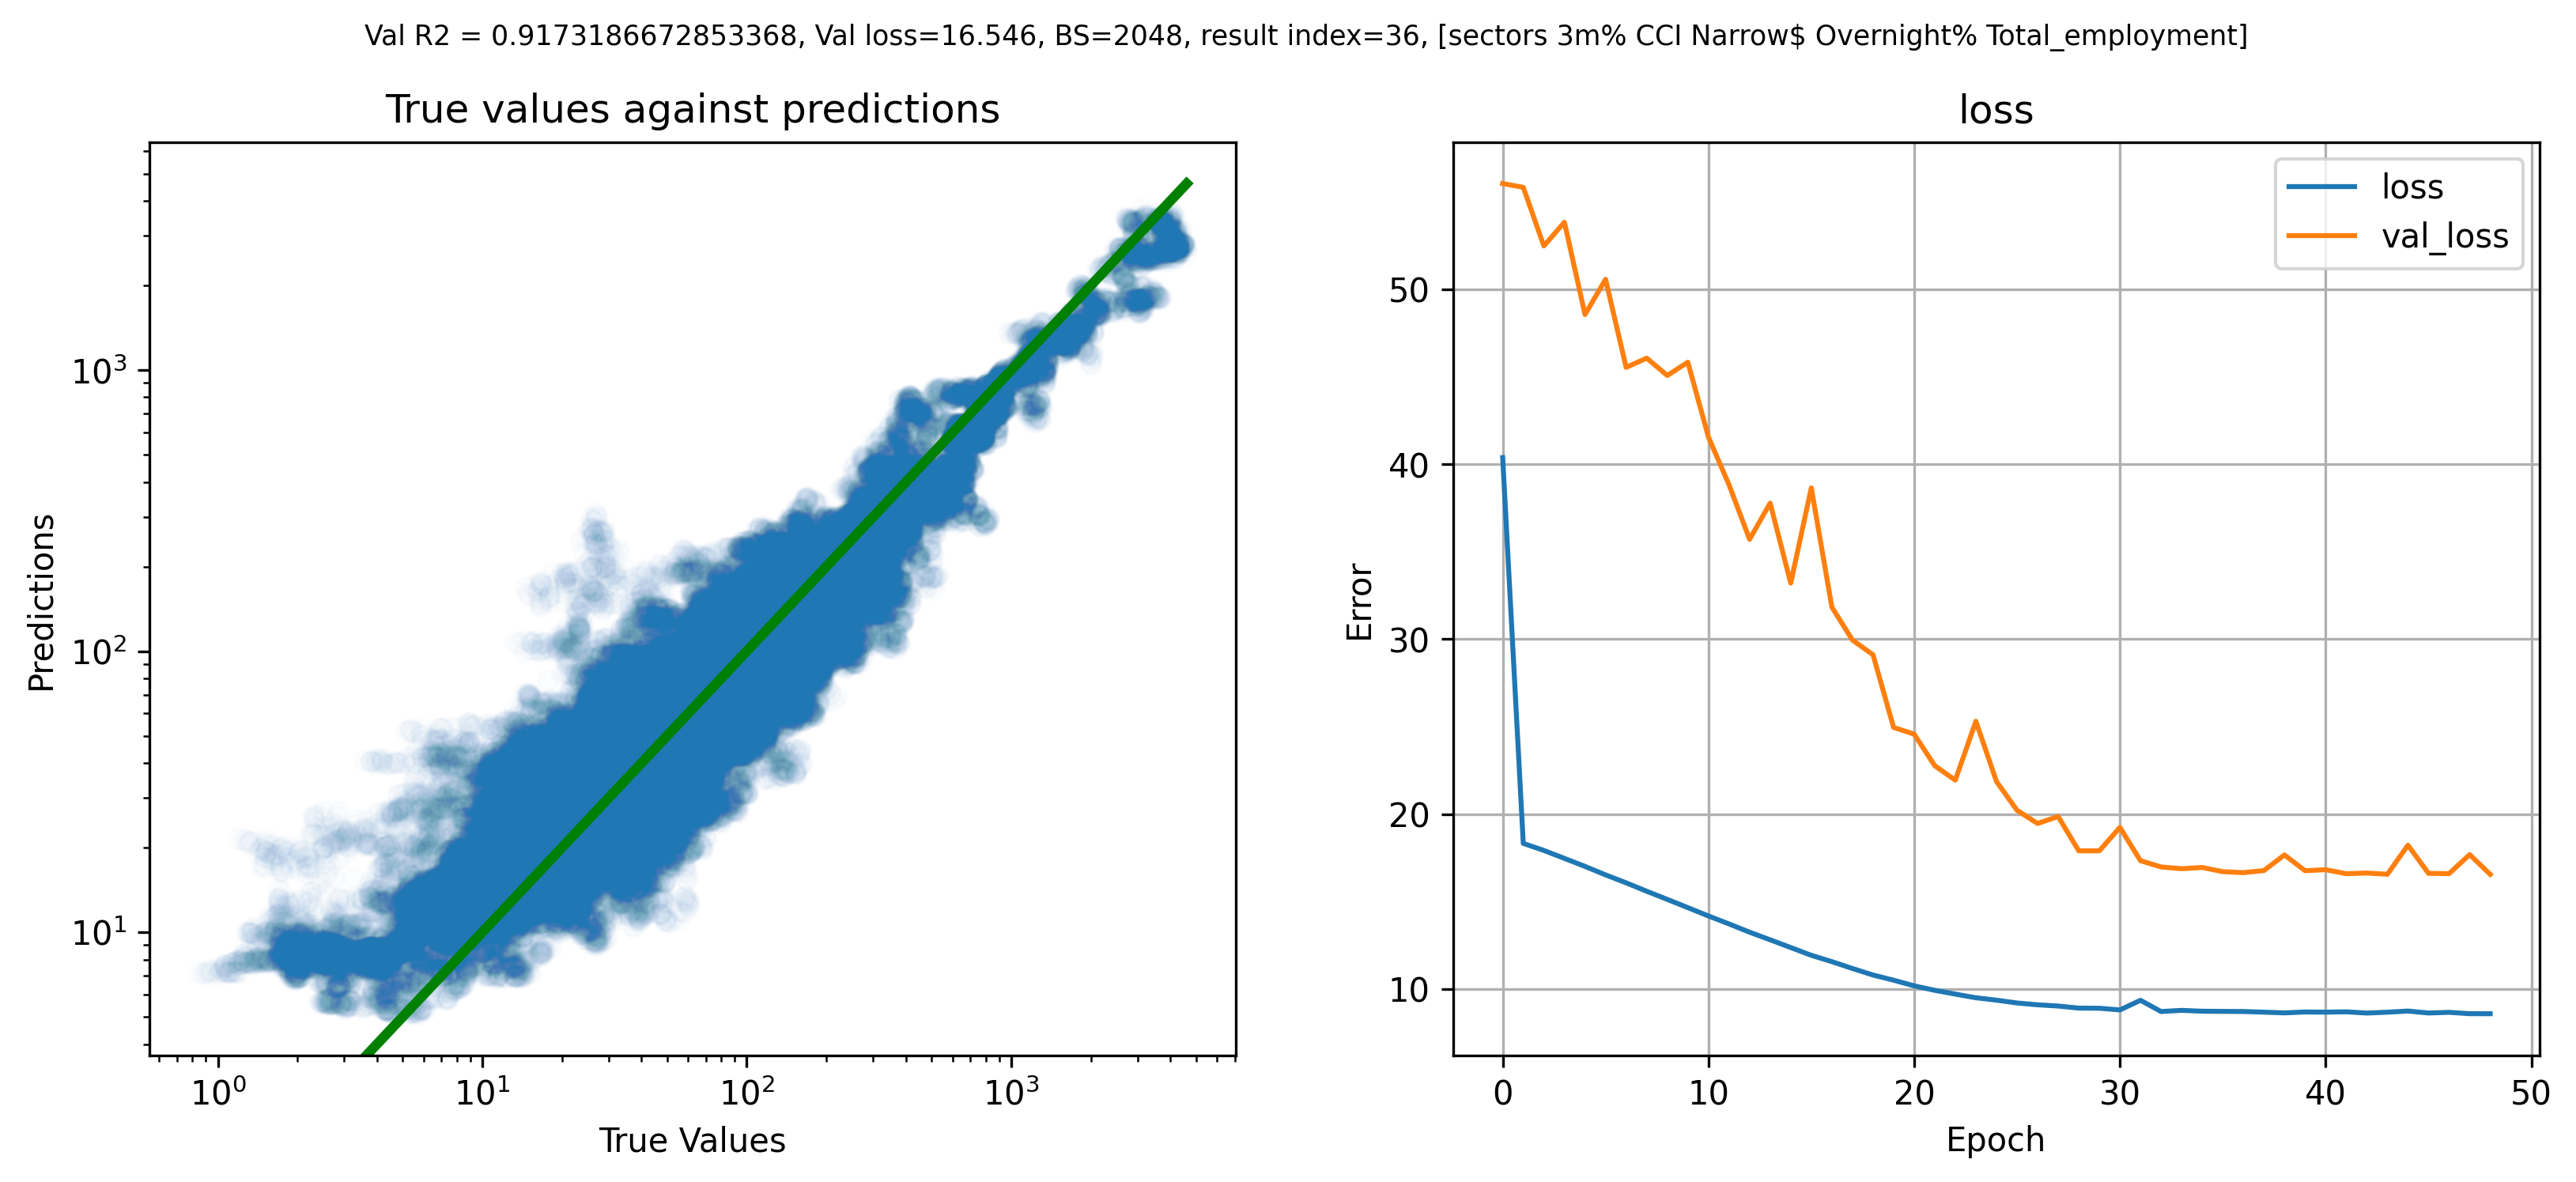

In [14]:
for i in range(len(args_df)):
    args = args_df.loc[i+3]
    create_model(*args)

# Create plotly graph for model results

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

results = pd.read_csv(model_results_path)

# Identifying the columns that can be used as x-axis variables
x_axis_options = results.columns.drop(['val_loss', 'val_r2'])

# Creating hover text that includes all column information for each point
hover_text_including_val_loss = results.apply(lambda row: '<br>'.join([f"{col}: {row[col]}" for col in results.columns]), axis=1)

# Creating the plot with layout adjustments
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=results[x_axis_options[0]], y=results['val_loss'], mode='markers', name='Loss',
                         hoverinfo="text", text=hover_text_including_val_loss), secondary_y=False)

# Updating the layout with a dropdown menu and y-axis title
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{"x": [results[column]], "hovertext": [hover_text_including_val_loss]}],
                    label=column,
                    method="restyle"
                ) for column in x_axis_options
            ]),
            direction="down",
            showactive=True,
            x=0.85,
            xanchor="left",
            y=1.10,  
            yanchor="top"
        ),
    ],
    title="Interactive Plot",
    yaxis_title="Validation Loss"
)

# Save the figure as an HTML file
html_file_path = f"{root_folder}/{overview_folder}/results.html"
fig.write_html(html_file_path)
print("plot saved")

plot saved
